In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.11.0+cpu


x min:  [-8.99994289]
x max: [8.99980426]
y min:  [-0.06006823]
y max: [0.05745778]


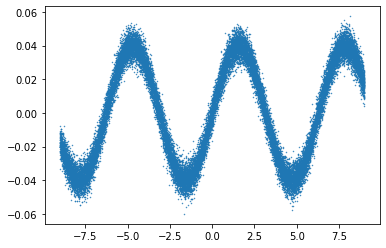

In [2]:
from re import X
n_x_train = 30000   # the number of training datapoints
n_x_test = 8000   # the number of testing datapoints

# Repeat data generation for test set
x_train = np.random.rand(n_x_train, 1)*18 - 9
y_train = (np.sin(x_train))/2.5
y_train += (np.random.randn(n_x_train, 1)/20)
y_train /= 10
# x_train = np.random.rand(n_x_train,1)*18 - 9  # Initialize a vector of with dimensions [n_x, 1] and extend
# y_train = x_train**2/20 #np.sign(x_train)           # Calculate the sin of all data points in the x vector and reduce amplitude
# y_train += (np.random.randn(n_x_train, 1)/5)  # add noise to each datapoint

# Repeat data generation for test set
x_test = np.random.rand(n_x_test, 1)*18 - 9
y_test = (np.sin(x_test))/2.5
y_test += (np.random.randn(n_x_test, 1)/20)
y_test /= 10
# x_test = np.random.rand(n_x_test,1)*18 - 9  # Initialize a vector of with dimensions [n_x, 1] and extend
# y_test = x_test**2/20 #np.sign(x_test)           # Calculate the sin of all data points in the x vector and reduce amplitude
# y_test += (np.random.randn(n_x_test, 1)/5)  # add noise to each datapoint

print("x min: ", min(x_train))
print("x max:", max(x_train))
print("y min: ", min(y_train))
print("y max:", max(y_train))

fig0 = plt.figure()  # initialize a plot
plt.scatter(x_train, y_train, marker='o', s=0.2)  # plot x vs y
plt.show()  # open a window with the plot (you have to close it for the script to finish)
# print(x_train)
# print(y_train)


In [3]:
class SineDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE or L1 Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length


In [4]:
def train_batch(model, x, y, optimizer, loss_fn):
    model.train()

    y_predict = model.forward(x)

    loss = loss_fn(y, y_predict)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    # Run forward calculation

    # Compute loss.

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)

    # Backward pass: compute gradient of the loss with respect to model
    # parameters

    # Calling the step function on an Optimizer makes an update to its
    # parameters

    return loss.data.item()


def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y,
                               optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses


In [5]:
def test_batch(model, x, y):
    # run forward calculation
    model.eval()

    y_predict = model(x)

    return y, y_predict


def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector


In [6]:
def plot_loss(losses, show=True):
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    ax = plt.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    plt.plot(x_loss, losses)

    if show:
        plt.show()

    plt.close()


## Define model architecture
Finally we can define a model to be trained. This is a very simple template that will not perform well on a complicated task. Without the activation function, this model would be a NN implementation of linear regression.

The following architecture parameters are defined here:
- number of layers
- size of layers
- activation function

This is where your weight matrices are defined. Between each layer, the weight matrix needs to have dimensions i x j where i is your input size and j is your output size. In other words, each weight contained in a matrix connects the i'th input node of the previous layer with the j'th output node of next layer. If your input layer is 40 and your output layer is 90, you need a 40 x 90 matrix to store all the connecting weights: torch.nn.Linear(40, 90).

In the forward() method, the input vector x is sequentially operated on by the layers of the model. The training and testing method calls forward() to calculate the model's output.

See the pytorch documentation for a full list of available activation functions:
http://pytorch.org/docs/master/nn.html#non-linear-activation-functions

Try switching between these 3 and see if there is a notable difference in the rate of convergence or closeness of the fit:
- `relu()`
- `sigmoid()`
- `tanh()`

Try adding more layers to the model by defining them in the init method and adding them to the forward pass method.

In [7]:
class ShallowLinear4(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''

    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear4, self).__init__()

        # Define network layer dimensions
        # These numbers correspond to each layer: [input, hidden_1, output]
        D_in, H1, H2, H3, D_out = [1, 15, 15, 15, 1]

        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x)  # hidden layer
        x = torch.relu(x)      # activation function

        x = self.linear2(x)  # hidden layer
        x = torch.relu(x)        # activation function

        x = self.linear3(x)  # hidden layer
        x = torch.relu(x)        # activation function

        x = self.linear4(x)  # output layer

        return x


In [8]:
class ShallowLinear2(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''

    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear2, self).__init__()

        # Define network layer dimensions
        # These numbers correspond to each layer: [input, hidden_1, output]
        D_in, H1, D_out = [1, 5,  1]

        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x)  # hidden layer
        x = torch.relu(x)      # activation function

        x = self.linear2(x)

        return x


In [9]:
class ShallowLinear1(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''

    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear1, self).__init__()

        # These numbers correspond to each layer: [input, hidden_1, output]
        D_in, D_out = [1, 1]

        self.linear1 = nn.Linear(D_in, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x)  # hidden layer

        return x


In [10]:
def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 16

    data_loader_train = DataLoader(
        dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(
        dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)

    # Define learning rate and model
    learning_rate = 5e-3
    model = ShallowLinear4()

    # Initialize the optimizer with above parameters
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Define the loss function
    # Use mean squared error
    loss_fn = nn.MSELoss()

    # Train and get the resulting loss per iteration
    loss = train(model, data_loader_train, optimizer, loss_fn, epochs=10)

    # Test and get the resulting predicted y values
    y_predict = test(model, data_loader_test)
    # print(model.linear1.weight)
    # print(model.linear1.bias)
    # print('###############')
    # print(model.linear2.weight)
    # print(model.linear2.bias)
    # print('###############')
    Y_, Y_Predict = test_batch(model=model, x=torch.Tensor(
        np.array([-5])), y=torch.Tensor(np.array([-5])))
    print(Y_, Y_Predict)
    # print('###############')
    return loss, y_predict


Train set size:  30000
Test set size:  8000
Epoch:  1
Batches:  1875
Epoch:  2
Batches:  3750
Epoch:  3
Batches:  5625
Epoch:  4
Batches:  7500
Epoch:  5
Batches:  9375
Epoch:  6
Batches:  11250
Epoch:  7
Batches:  13125
Epoch:  8
Batches:  15000
Epoch:  9
Batches:  16875
Epoch:  10
Batches:  18750
tensor([-5.]) tensor([0.0190], grad_fn=<AddBackward0>)
Final loss: 0.00038589774034335277


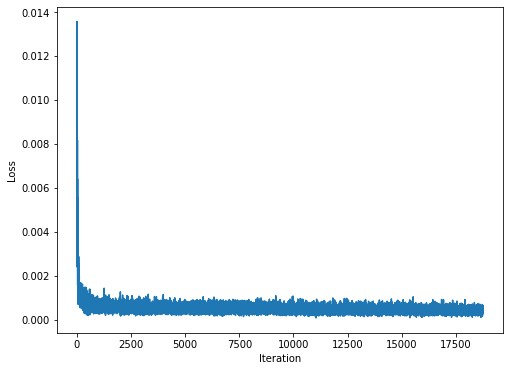

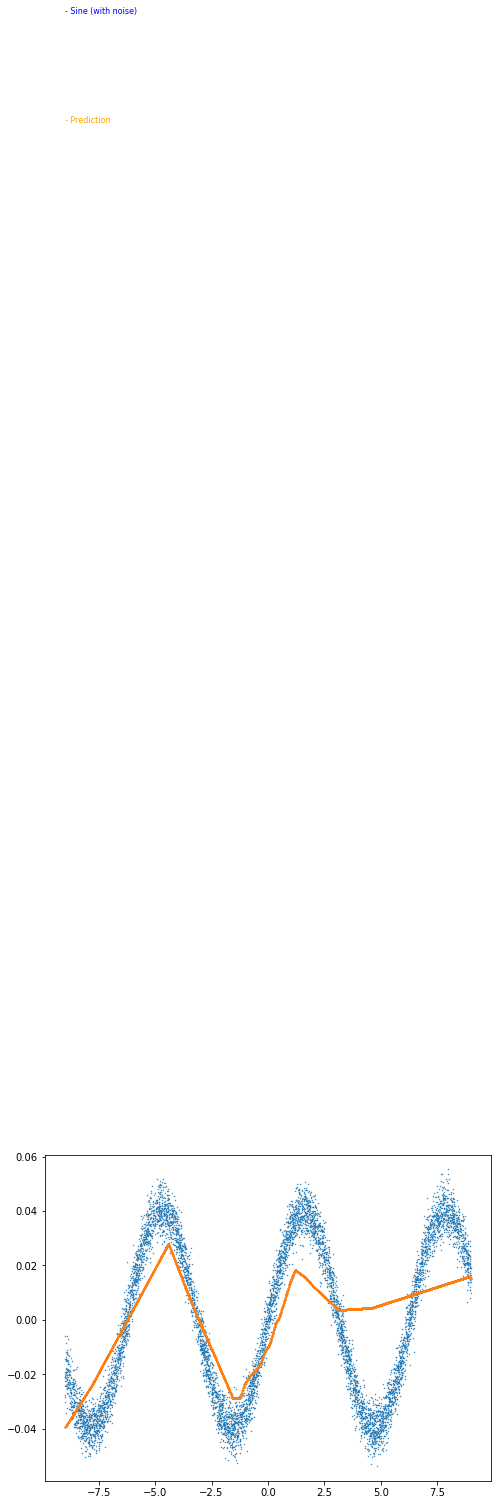

In [11]:
dataset_train = SineDataset(x=x_train, y=y_train)
dataset_test = SineDataset(x=x_test, y=y_test)

print("Train set size: ", dataset_train.length)
print("Test set size: ", dataset_test.length)

losses, y_predict = run(dataset_train=dataset_train, dataset_test=dataset_test)

print("Final loss:", sum(losses[-100:])/100)
plot_loss(losses)

fig2 = plt.figure()
fig2.set_size_inches(8, 6)
plt.scatter(x_test, y_test, marker='o', s=0.2)
plt.scatter(x_test, y_predict, marker='o', s=0.3)
plt.text(-9, 0.44, "- Prediction", color="orange", fontsize=8)
plt.text(-9, 0.48, "- Sine (with noise)", color="blue", fontsize=8)
plt.show()
